In [1]:
%reset
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.ticker as mticker
import warnings; warnings.filterwarnings('ignore')
import cmocean
from gsw import alpha, SA_from_SP, p_from_z, CT_from_pt, beta, sigma1 

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [2]:
from pylab import *
from numpy import *
from matplotlib.colors import LinearSegmentedColormap
class nlcmap(LinearSegmentedColormap):
    """A nonlinear colormap"""

    name = 'nlcmap'

    def __init__(self, cmap, levels):
        self.cmap = cmap
        self.monochrome = self.cmap.monochrome
        self.levels = asarray(levels, dtype='float64')
        self._x = self.levels-self.levels.min()
        self._x/= self._x.max()
        self._y = linspace(0, 1, len(self.levels))

    def __call__(self, xi, alpha=1.0, **kw):
        yi = interp(xi, self._x, self._y)
        return self.cmap(yi, alpha)

In [3]:
%cd /archive/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/
%cd pp/ocean_annual_z/
fs=xr.open_dataset('ocean_annual_z.static.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
Coriolis = fs['Coriolis'];
dx = fs['dxt']; dy = fs['dyt']; dxy= (dx**2+dy**2)**0.5
print(dxy.shape)

print(fs)
%cd av/annual_20yr/

/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod
/arch9/ogrp/CMIP6/OMIP/warsaw_201803_mom6_2018.04.06/OM4p25_IAF_BLING_CFC_csf/gfdl.ncrc4-intel16-prod/pp/ocean_annual_z
(1080, 1440)
<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1080, yq: 1080)
Coordinates:
  * xh            (xh) float64 -299.7 -299.5 -299.2 -299.0 ... 59.53 59.78 60.03
  * xq            (xq) float64 -299.6 -299.3 -299.1 -298.9 ... 59.66 59.91 60.16
  * yh            (yh) float64 -80.39 -80.31 -80.23 -80.15 ... 89.73 89.84 89.95
  * yq            (yq) float64 -80.35 -80.27 -80.19 -80.11 ... 89.78 89.89 90.0
Data variables:
    geolat        (yh, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    geolon        (yh, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    areacello     (yh, xh) float32 ...
    areacello_bu  (yq, xq) float32 ...
    areacello_cu  (yh, xq) float32 ...
    areacello_cv  (yq, xh

In [4]:
data=xr.open_dataset('ocean_annual_z.1988-2007.ann.nc')['time']
i=0 #month starting from 2003-01-01
a=str(data[i].values); title=a
print(title)

fhist = xr.open_mfdataset(['ocean_annual_z.1988-2007.ann.nc'])

print(fhist)


1998-01-01 00:00:00
<xarray.Dataset>
Dimensions:                         (nv: 2, time: 1, xh: 1440, xq: 1440, yh: 1080, yq: 1080, z_i: 36, z_l: 35)
Coordinates:
  * xh                              (xh) float64 -299.7 -299.5 ... 59.78 60.03
  * yh                              (yh) float64 -80.39 -80.31 ... 89.84 89.95
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
  * time                            (time) object 1998-01-01 00:00:00
  * nv                              (nv) float64 1.0 2.0
  * xq                              (xq) float64 -299.6 -299.3 ... 59.91 60.16
  * yq                              (yq) float64 -80.35 -80.27 ... 89.89 90.0
Data variables:
    volcello                        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1080, 1440), meta=np.ndarray>
    thetao                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1080, 14

In [26]:
zi=np.array(fhist.variables['z_i'])
dz=np.diff(zi)
uo=np.array(fhist.variables['uo'][0,0,:,:])
vo=np.array(fhist.variables['vo'][0,0,:,:])
KE=0.5*(uo**2+vo**2)

N=(np.array(fhist.variables['obvfsq'][0,1:20,:,:]))**0.5 #Buoyancy frequency
a=(dz[0:19])
b=np.tile(a,[1080,1440,1])
dzmat=np.moveaxis(b, [0, 1, 2], [1, 2,0])


#We are computing Rossby Radius of Deformation by integrating N over the uppermost 1050 meters.
#print(zi[1:20])
#print(dz[0:19])
print(KE.shape)
print(N.shape)
print(dzmat.shape)
#print(dzmat[:,5,5])
#print(dzmat[:,500,500])

Lr1=np.nansum(N*dzmat,axis=0)
Lr=Lr1/(abs(Coriolis)*pi*1000)

mask=uo*0.0+1.0;
#Lr.shape
#print(zi[1:20])

(1080, 1440)
(19, 1080, 1440)
(19, 1080, 1440)


Text(0.5, 1.0, 'Surface KE, 1/4$^\\circ$ OM4')

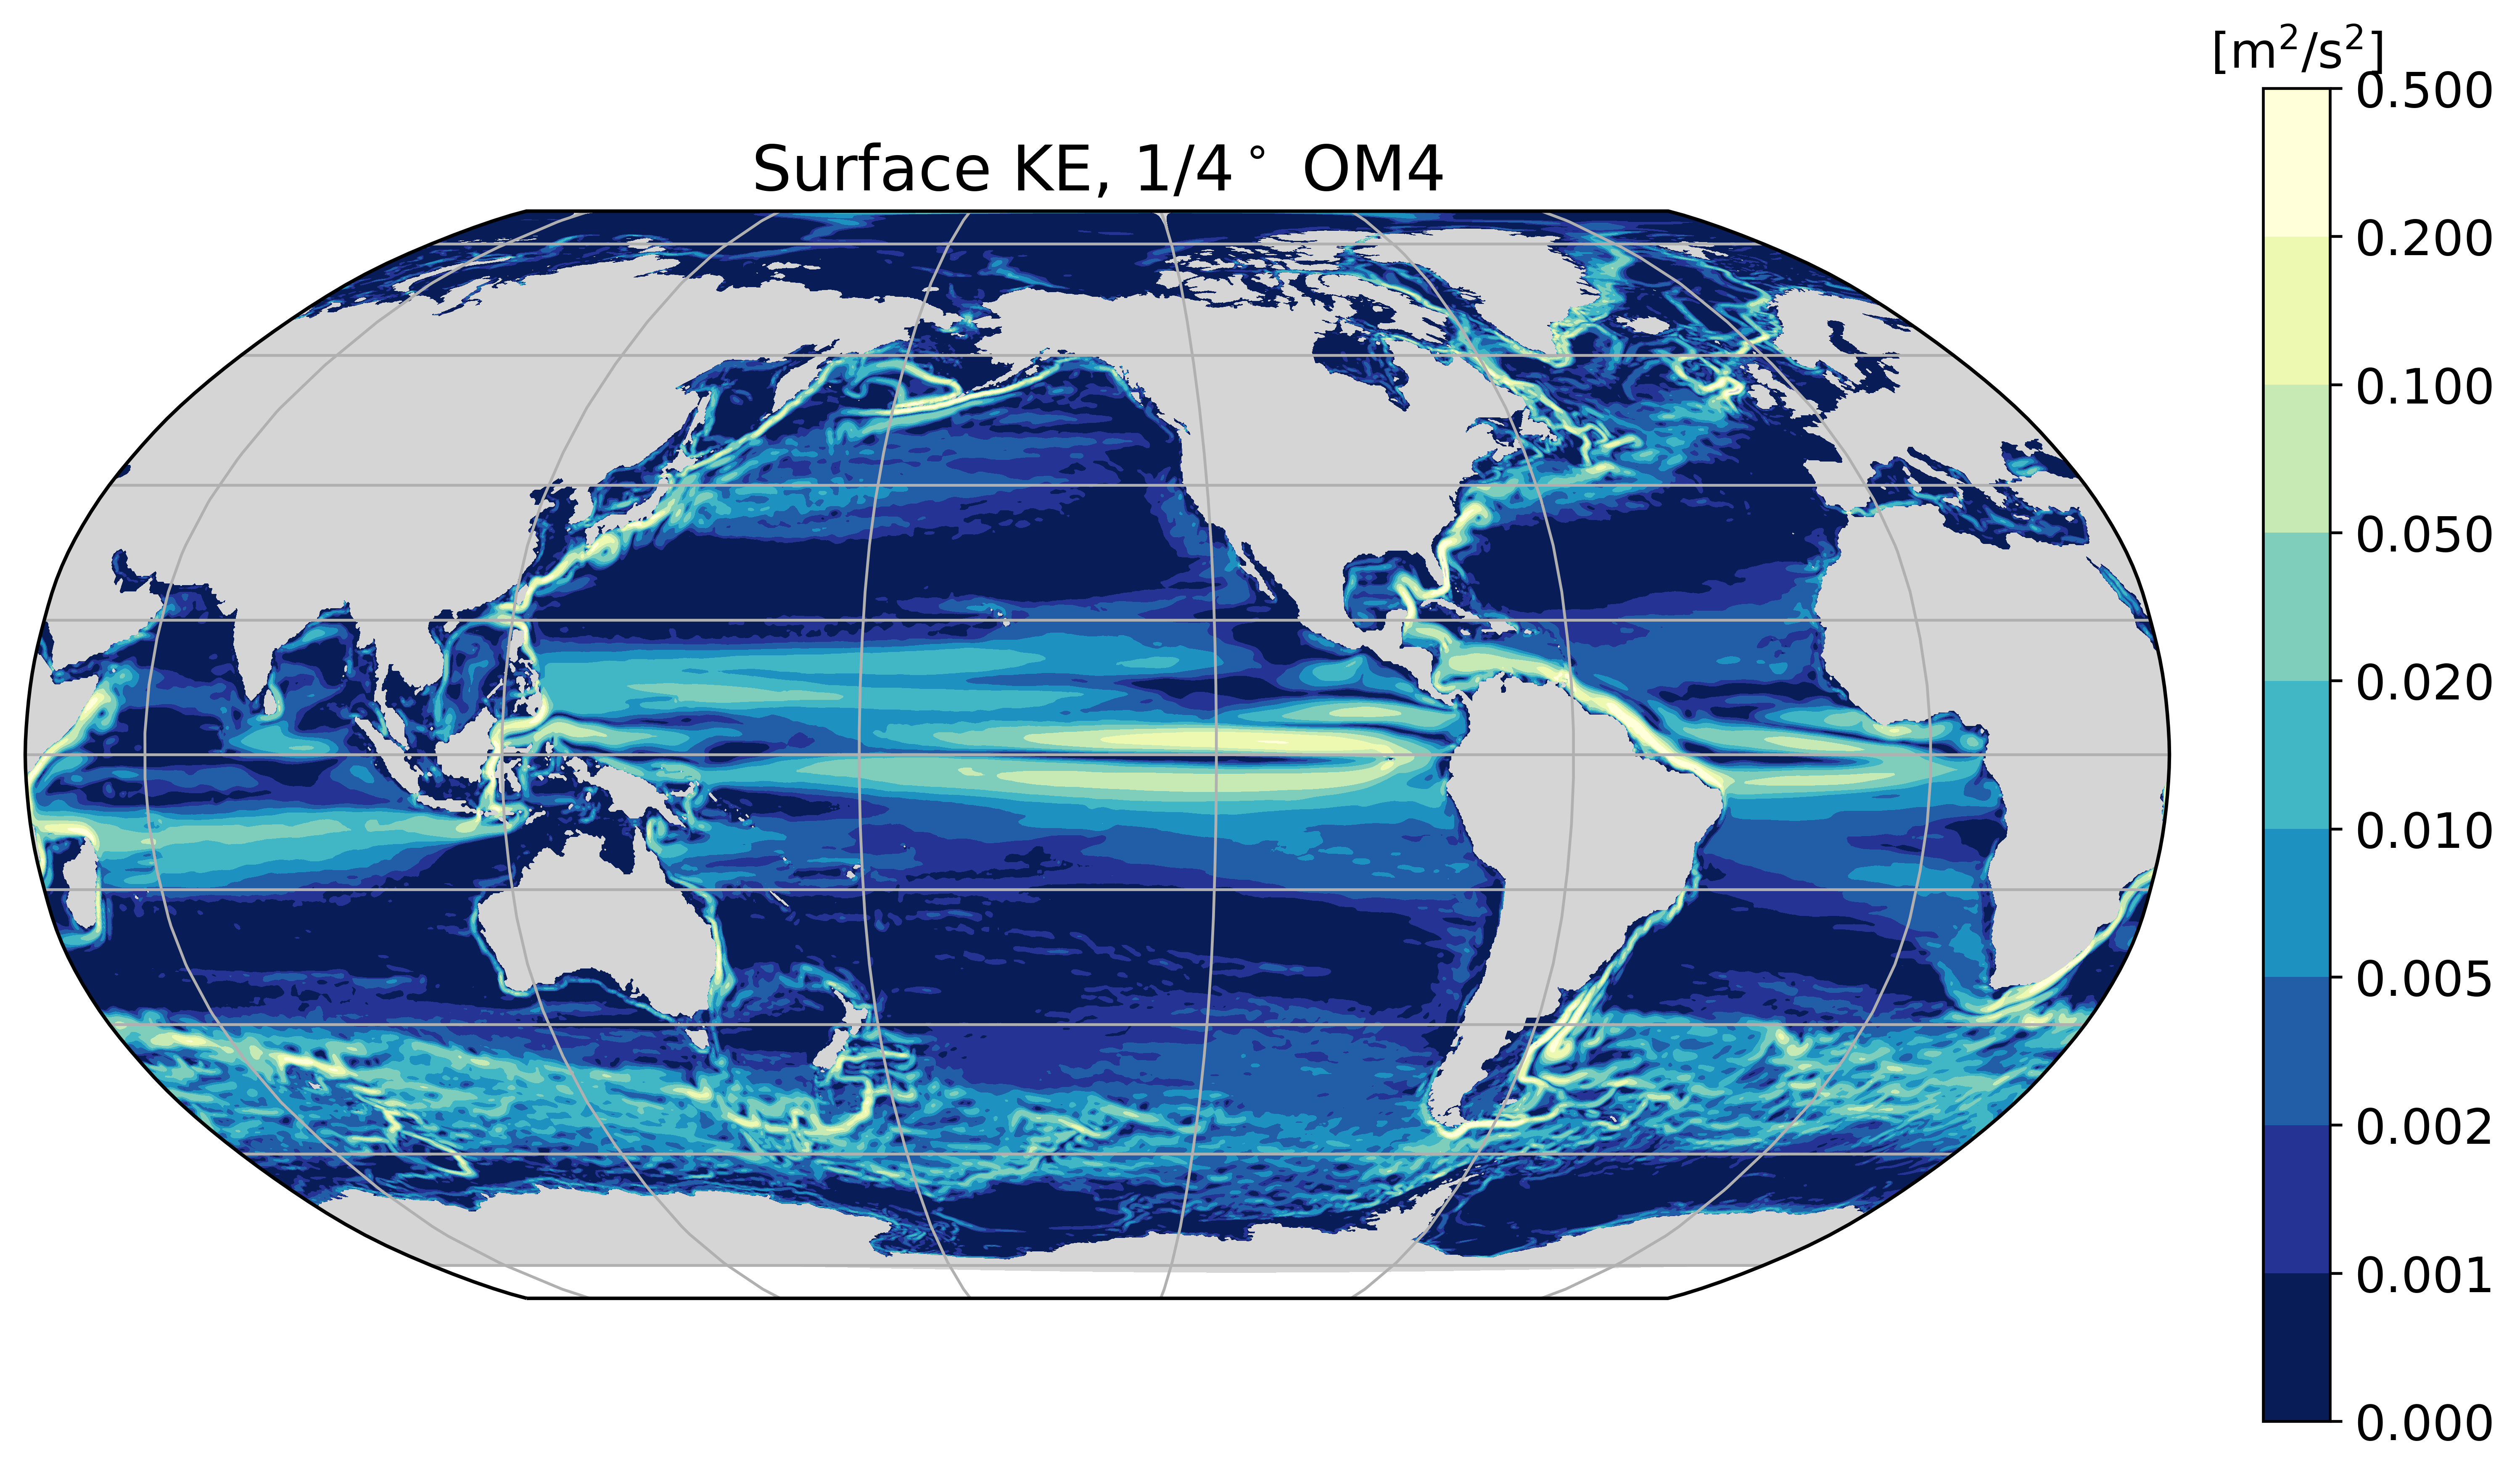

In [23]:
#fig = plt.figure(figsize=(10, 5))
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
#ax.set_extent([-180, 180, -90, 90],ccrs.PlateCarree())

cmap_lin = plt.get_cmap('YlGnBu_r', 9)
ticklevel=[0.000,0.001,0.002,0.005,0.010,0.020,0.050,0.100,0.200,0.500]
cmap_nonlin = nlcmap(cmap_lin, ticklevel)

plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1.2);

plot1=plt.contourf(lon,lat,KE*mask,ticklevel,transform=ccrs.PlateCarree(),cmap=cmap_nonlin);

cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m$^2$/s$^2$]', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Surface KE, 1/4$^\circ$ OM4',fontsize=18) #positive into ocean



Text(0.5, 1.0, 'Rossby Radius $L_R$ 1/4$^\\circ$ OM4')

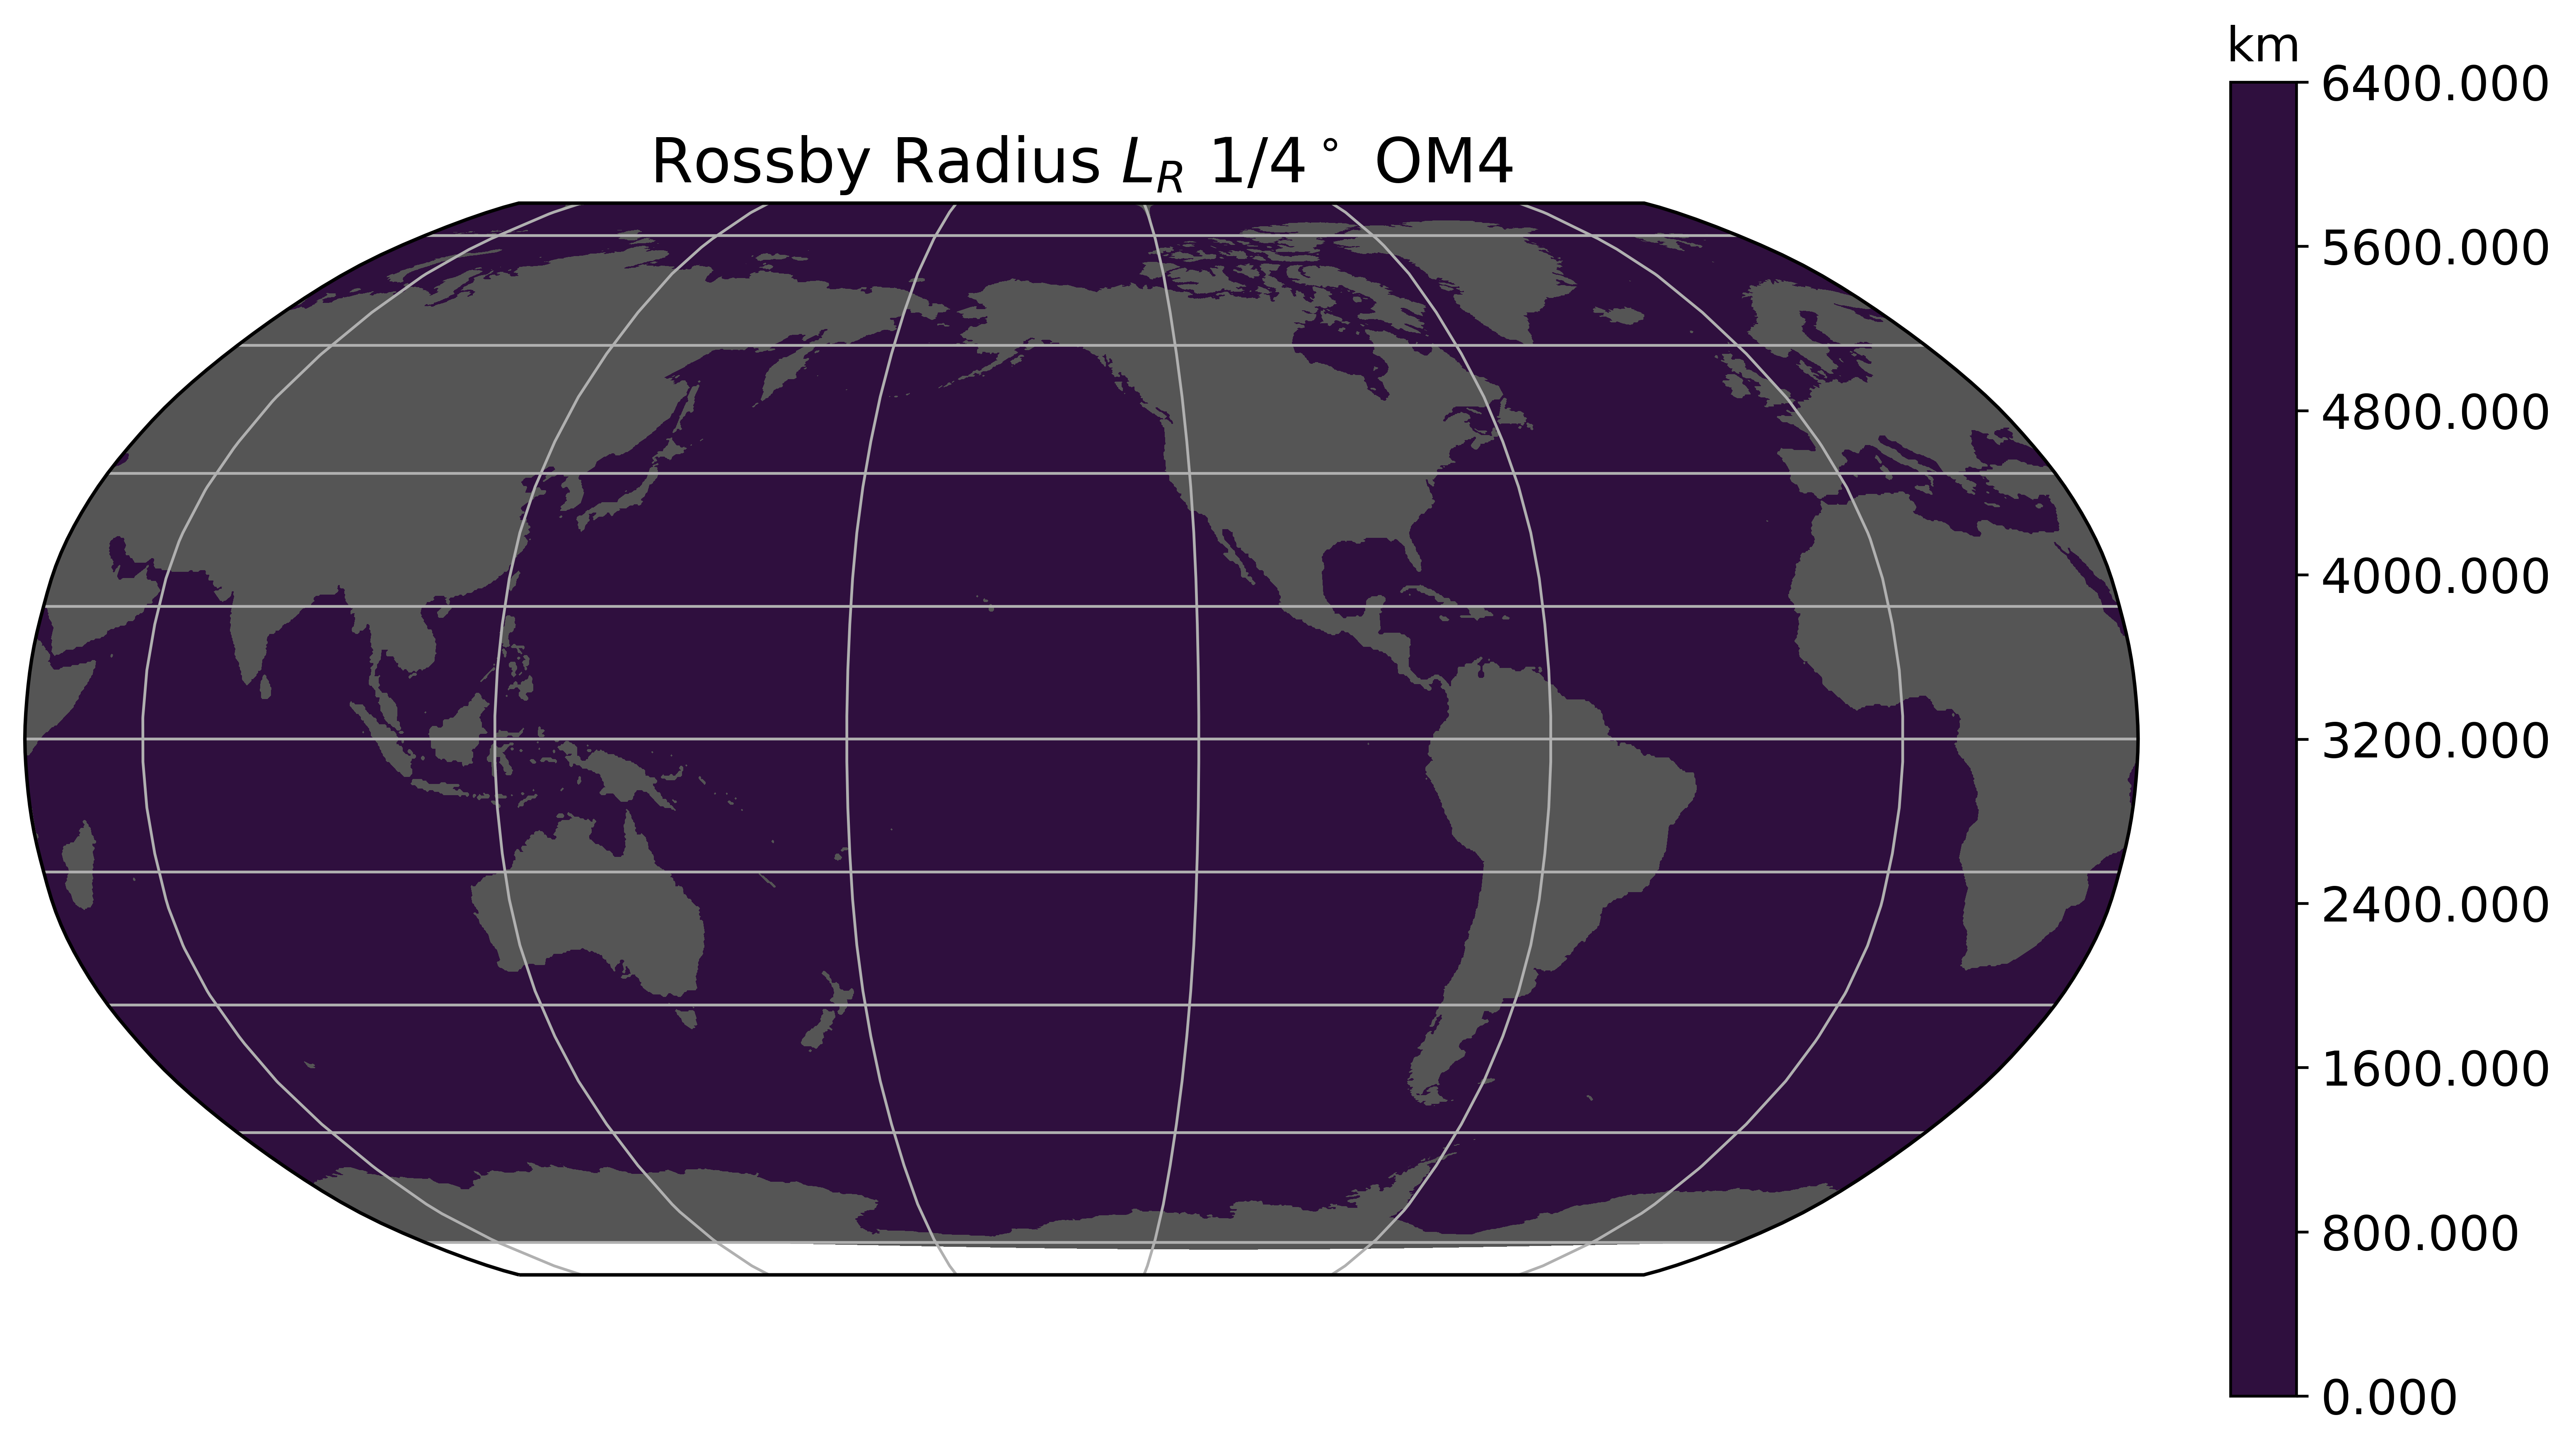

In [27]:
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))

cmap_lin = plt.get_cmap(cmocean.cm.matter, 256)
plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1.2);
plt.contourf(lon,lat,Lr*mask,transform=ccrs.PlateCarree(),cmap=cmap_lin,vmin=0,vmax=50);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('km', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Rossby Radius $L_R$ 1/4$^\circ$ OM4',fontsize=18) #positive into ocean


Text(0.5, 1.0, '$(dx^2+dy^2)^{1/2} $ 1/4$^\\circ$ OM4')

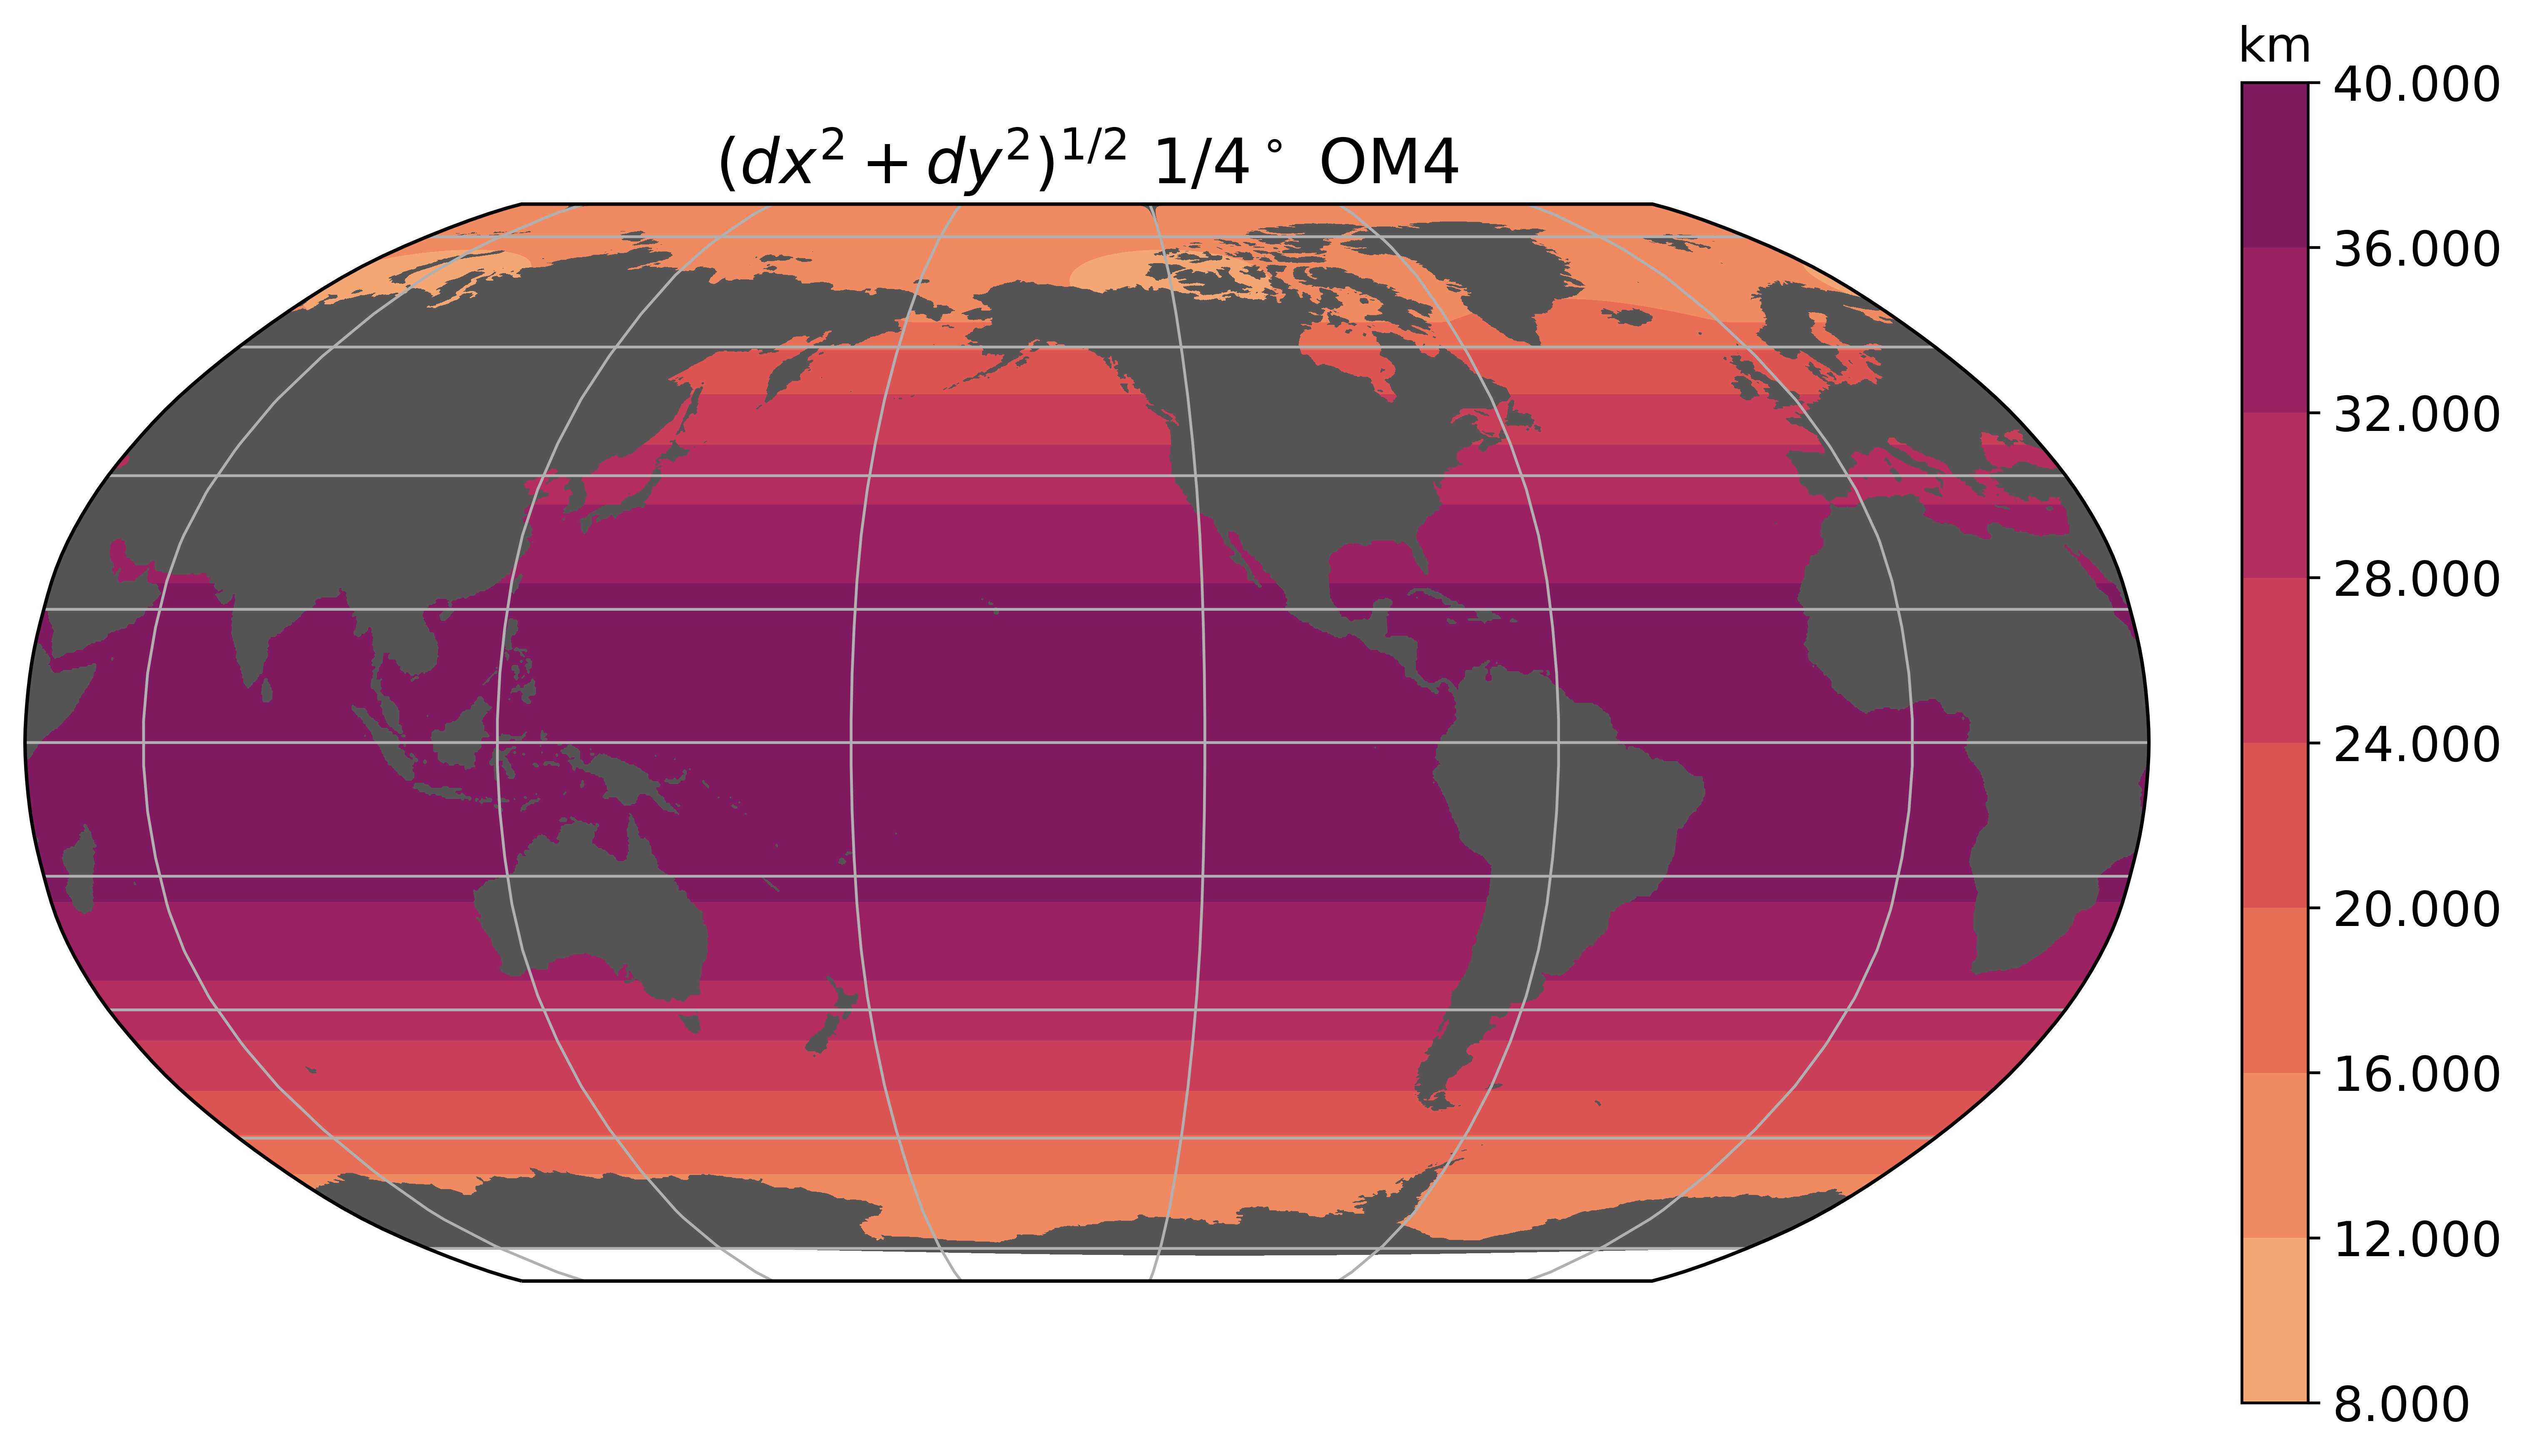

In [28]:
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))

cmap_lin = plt.get_cmap(cmocean.cm.matter, 256)
plt.pcolormesh(lon, lat,np.ones((1080,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=3);
plt.contourf(lon,lat,dxy*mask/1000,transform=ccrs.PlateCarree(),cmap=cmap_lin,vmin=0,vmax=50);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('km', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('$(dx^2+dy^2)^{1/2} $ 1/4$^\circ$ OM4',fontsize=18) #positive into ocean



In [13]:
print(pi)

3.141592653589793


In [37]:
%cd /archive/Raphael.Dussin/datasets/OM4p125/OM4p125_grid_20200213_merged_bathy_unpacked

fs=xr.open_dataset('ocean_static_d2.nc')
deptho=fs['deptho'][:,:]
lon=fs['geolon']; lat=fs['geolat']
lonu=fs['geolon_u']; latu=fs['geolat_u']
lonv=fs['geolon_v']; latv=fs['geolat_v']
print(fs)
%cd /archive/Raphael.Dussin/xanadu_esm4_20190304_mom6_2019.12.16/OM4p125_JRA55do1.4_mle3d_cycle3/gfdl.ncrc4-intel16-prod/
%cd pp/ocean_annual_z_d2/av/annual_20yr/

/arch2/rnd/datasets/OM4p125/OM4p125_grid_20200213_merged_bathy_unpacked
<xarray.Dataset>
Dimensions:       (xh: 1440, xq: 1440, yh: 1120, yq: 1120)
Coordinates:
  * xh            (xh) float64 -298.5 -298.3 -298.1 -297.8 ... 60.77 61.0 61.23
  * yq            (yq) float64 -83.56 -83.48 -83.41 -83.33 ... 89.78 89.89 90.0
  * xq            (xq) float64 -298.4 -298.2 -298.0 -297.7 ... 60.89 61.12 61.35
  * yh            (yh) float64 -83.6 -83.52 -83.45 -83.37 ... 89.73 89.84 89.95
Data variables:
    geolon        (yh, xh) float32 ...
    geolon_u      (yh, xq) float32 ...
    geolon_v      (yq, xh) float32 ...
    geolon_c      (yq, xq) float32 ...
    geolat        (yh, xh) float32 ...
    geolat_u      (yh, xq) float32 ...
    geolat_v      (yq, xh) float32 ...
    geolat_c      (yq, xq) float32 ...
    Coriolis      (yq, xq) float32 ...
    dxt           (yh, xh) float32 ...
    dxCu          (yh, xq) float32 ...
    dxCv          (yq, xh) float32 ...
    dyt           (yh, xh) float32

In [38]:
data=xr.open_dataset('ocean_annual_z_d2.1998-2017.ann.nc')['time']
i=0 #month starting from 2003-01-01
a=str(data[i].values); title=a
print(title)

fhist = xr.open_mfdataset(['ocean_annual_z_d2.1998-2017.ann.nc'])

#print(fhist)

2008-01-01 12:00:00
<xarray.Dataset>
Dimensions:                         (nv: 2, time: 1, xh: 1440, xq: 1440, yh: 1120, yq: 1120, z_i: 36, z_l: 35)
Coordinates:
  * xh                              (xh) float64 -298.6 -298.4 ... 60.93 61.16
  * yh                              (yh) float64 -83.62 -83.54 ... 89.81 89.92
  * z_l                             (z_l) float64 2.5 10.0 ... 6e+03 6.5e+03
  * z_i                             (z_i) float64 0.0 5.0 ... 6.25e+03 6.75e+03
  * time                            (time) object 2008-01-01 12:00:00
  * nv                              (nv) float64 1.0 2.0
  * xq                              (xq) float64 -298.5 -298.3 ... 61.0 61.23
  * yq                              (yq) float64 -83.6 -83.52 ... 89.84 89.95
Data variables:
    volcello                        (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 1440), meta=np.ndarray>
    thetao                          (time, z_l, yh, xh) float32 dask.array<chunksize=(1, 35, 1120, 144

In [50]:
zi=np.array(fhist.variables['z_i'])
dz=np.diff(zi)
uo=np.array(fhist.variables['uo'][0,0,:,:])
vo=np.array(fhist.variables['vo'][0,0,:,:])
KE=0.5*(uo**2+vo**2)
N2=np.array()

print(zi)
print(KE.shape)
print(np.nanmean(KE))

[0.000e+00 5.000e+00 1.500e+01 2.500e+01 4.000e+01 6.250e+01 8.750e+01
 1.125e+02 1.375e+02 1.750e+02 2.250e+02 2.750e+02 3.500e+02 4.500e+02
 5.500e+02 6.500e+02 7.500e+02 8.500e+02 9.500e+02 1.050e+03 1.150e+03
 1.250e+03 1.350e+03 1.450e+03 1.625e+03 1.875e+03 2.250e+03 2.750e+03
 3.250e+03 3.750e+03 4.250e+03 4.750e+03 5.250e+03 5.750e+03 6.250e+03
 6.750e+03]
(1120, 1440)
0.005777449


In [49]:
print(dz)

[  5.   10.   10.   15.   22.5  25.   25.   25.   37.5  50.   50.   75.
 100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  100.  175.
 250.  375.  500.  500.  500.  500.  500.  500.  500.  500.  500. ]


Text(0.5, 1.0, 'Surface KE, 1/8$^\\circ$ OM4')

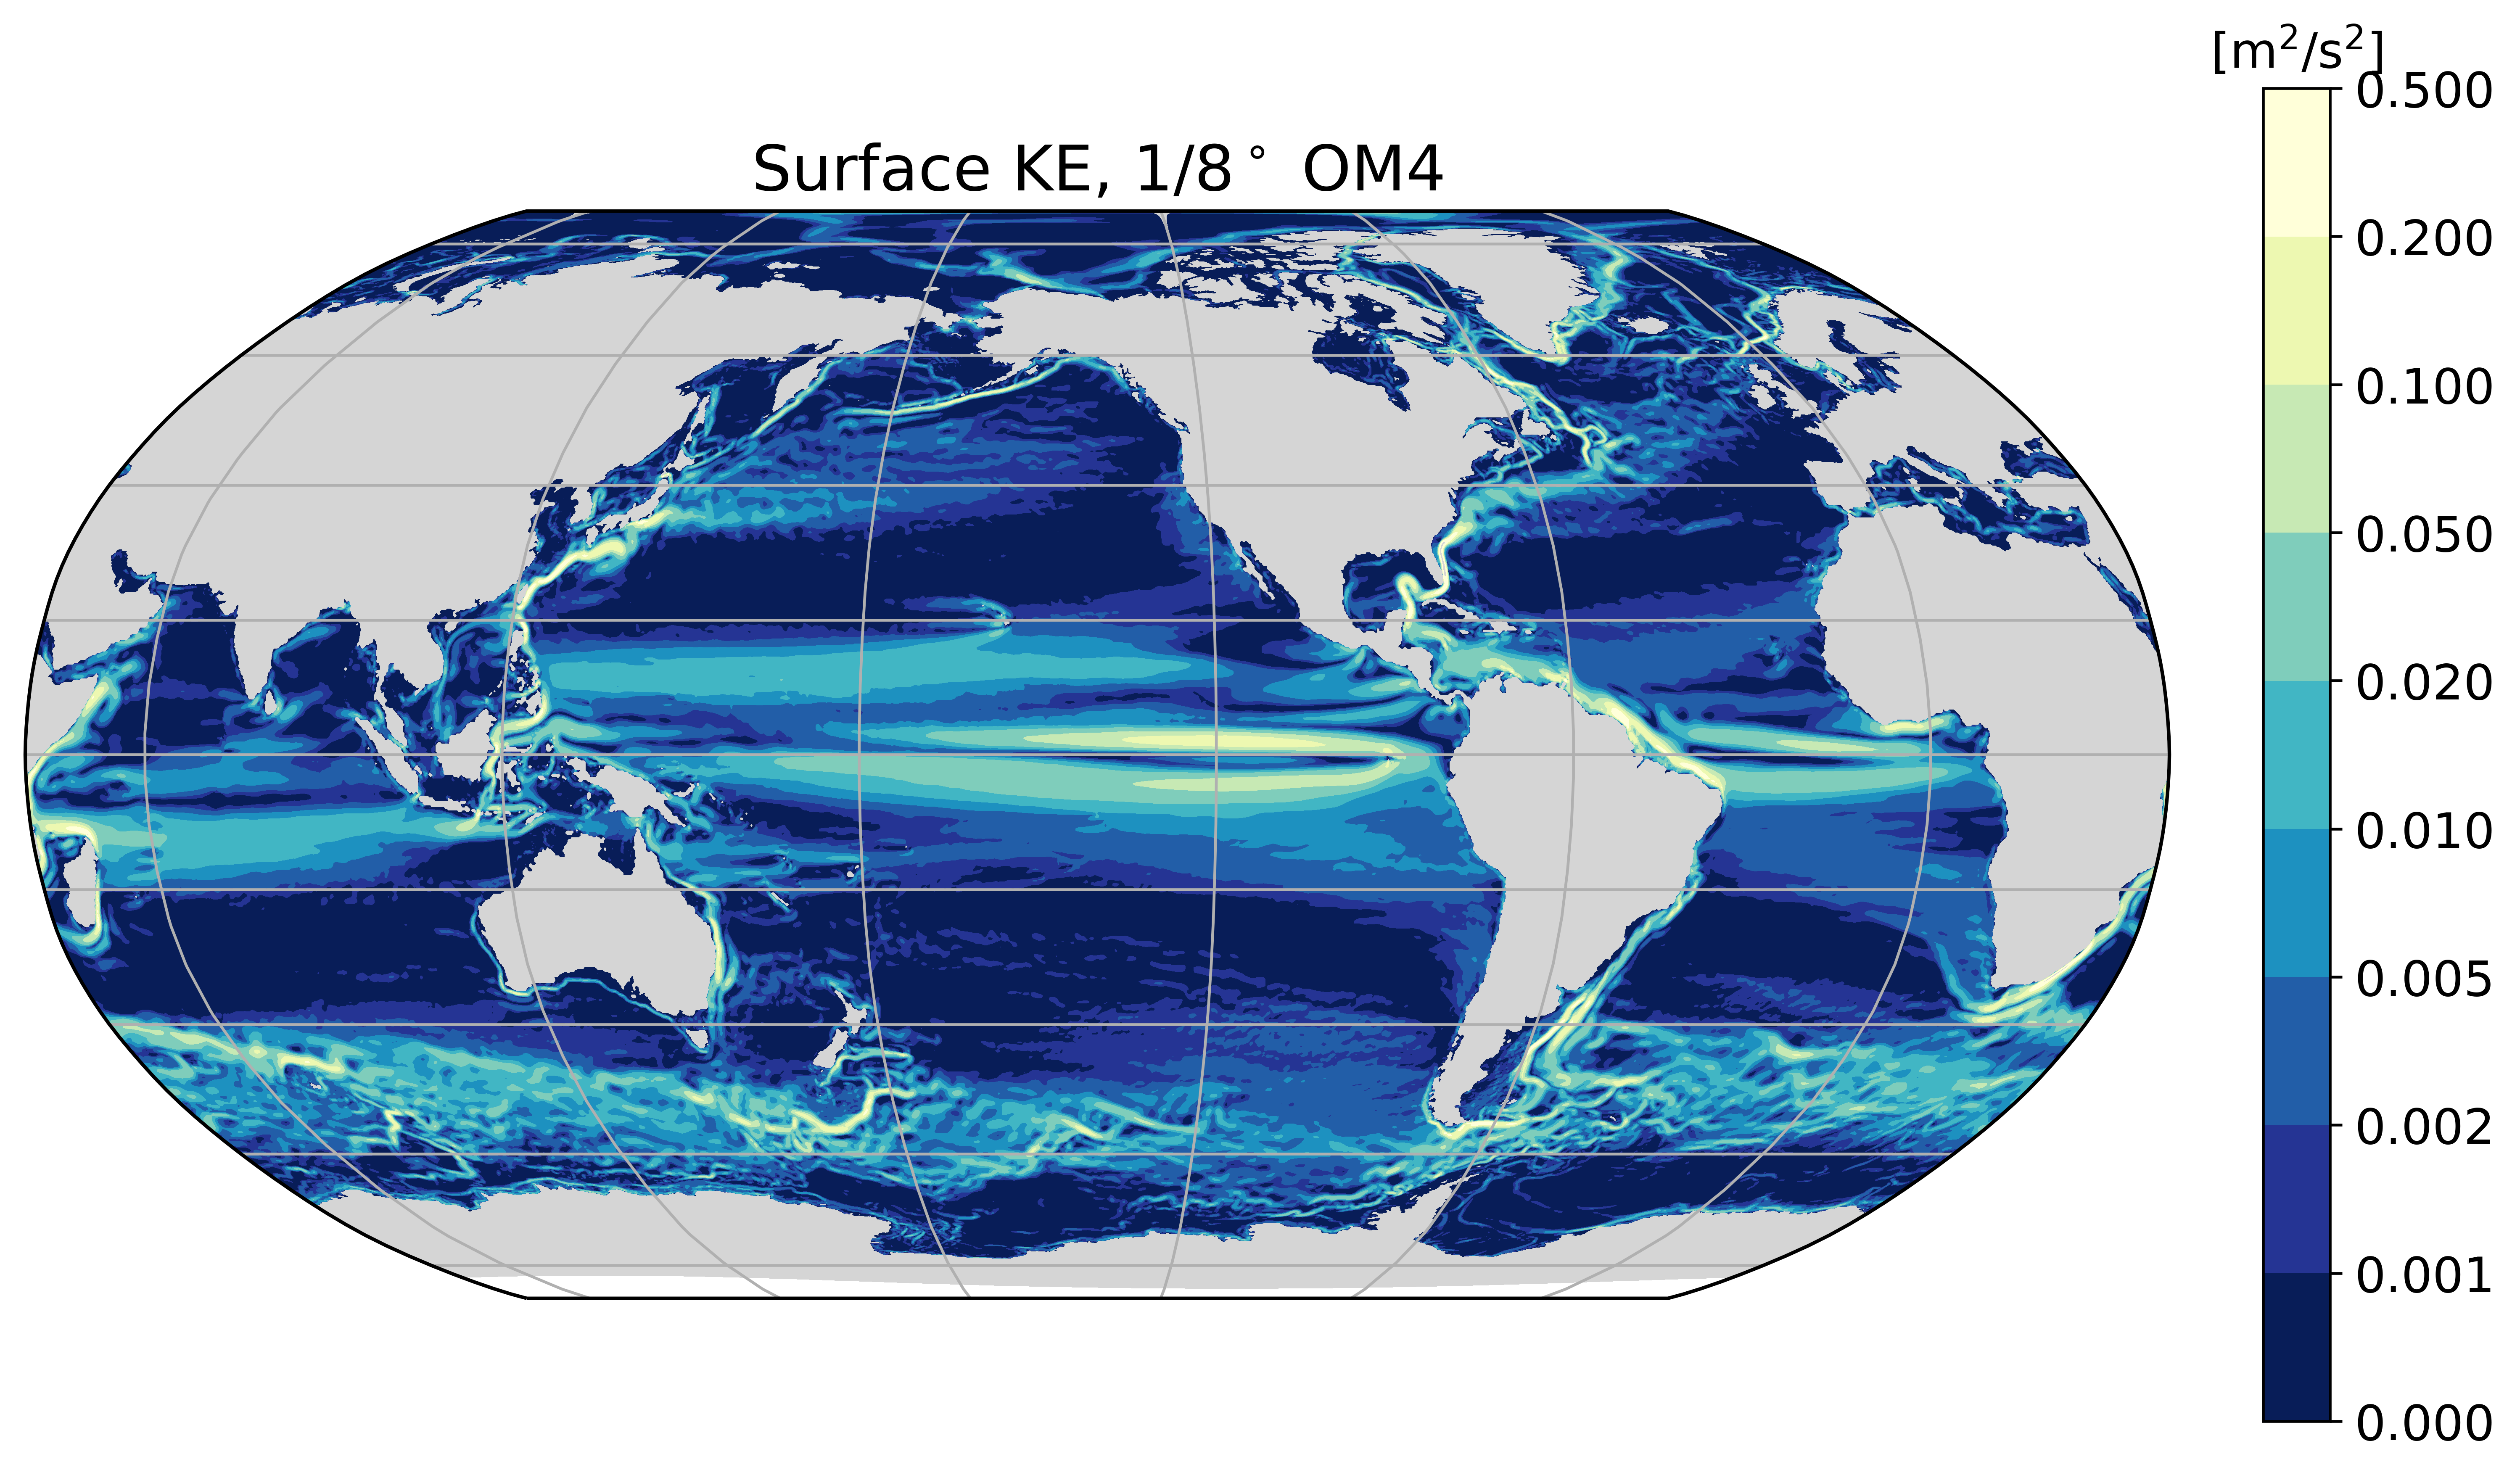

In [24]:
fig = plt.figure(figsize=(12, 7), dpi= 600, facecolor='w', edgecolor='k')
ax = plt.axes(projection=ccrs.Robinson(central_longitude=-140))
#ax.set_extent([-180, 180, -90, 90],ccrs.PlateCarree())

cmap_lin = plt.get_cmap('YlGnBu_r', 9)
ticklevel=[0.000,0.001,0.002,0.005,0.010,0.020,0.050,0.100,0.200,0.500]
cmap_nonlin = nlcmap(cmap_lin, ticklevel)

plt.pcolormesh(lon, lat,np.ones((1120,1440)),transform=ccrs.PlateCarree(),cmap='gray',vmin=0,vmax=1.2);

plot1=plt.contourf(lon,lat,KE,ticklevel,transform=ccrs.PlateCarree(),cmap=cmap_nonlin);


cbar=plt.colorbar(fraction=0.046, pad=0.04,format='%.3f'); cbar.ax.tick_params(labelsize=14);
cbar.ax.set_title('[m$^2$/s$^2$]', fontsize=14)

gl=ax.gridlines(crs=ccrs.PlateCarree())
plt.title('Surface KE, 1/8$^\circ$ OM4',fontsize=18) #positive into ocean
